In [6]:
import sys
from utils import print_json
from utils.cloudant_utils import cloudant_db as db, save_doc
from datetime import date
import numpy as np
import pandas as pd

In [7]:
repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], 
                                        limit=10000, raw_result=True)["docs"]]
repos[0]['releases'][0].keys()

dict_keys(['repo', 'release_tag', 'release_date', 'downloads', 'stars', 'watchers', 'forks', 'commits', 'issues', 'total_stars', 'total_forks', 'total_commits', 'contributors', 'total_issues', 'total_closedIssues', 'closedIssues', 'readme', 'readme_size'])

In [8]:
values = [r for release in repos for r in release["releases"]]
df = pd.DataFrame(values)
df.shape 

(44043, 19)

# clean the data 

In [11]:
# df['contributors'] = df['contributors'].apply(lambda d: d if isinstance(d, list) else [])
# df['contributors'] = df['contributors'].apply(lambda x: [i for i in x if i is not None] )
df['contributors'] = df['contributors'].apply(lambda x: 
                                              [i for i in x if i is not None] if isinstance(x, list)
                                              else [])

In [12]:
# df['contributors'].str.len()
# new_df['contributor_count'] = new_df['contributors'].apply(lambda x: len(x))
# df['contributor_count'] = df.contributors.map(len)

# Make a copy of Original dataframe

In [13]:
new_df = df[['repo', 'release_tag', 'release_date', 'downloads', 'stars', 'forks', 'commits', 
             'issues', 'closedIssues', 'readme', 'readme_size', 'contributors']].copy()

In [14]:
corrrelation= new_df.corr(method="pearson")
print("Pearson correlation coefficient:")
print(corrrelation)

Pearson correlation coefficient:
              downloads     stars     forks   commits    issues  closedIssues  \
downloads      1.000000  0.043922  0.043820  0.014487 -0.002087     -0.002513   
stars          0.043922  1.000000  0.816321  0.195427  0.122044      0.093542   
forks          0.043820  0.816321  1.000000  0.194920  0.059695      0.043666   
commits        0.014487  0.195427  0.194920  1.000000  0.241784      0.243474   
issues        -0.002087  0.122044  0.059695  0.241784  1.000000      0.908576   
closedIssues  -0.002513  0.093542  0.043666  0.243474  0.908576      1.000000   
readme_size   -0.006683  0.079201  0.049521  0.067220  0.050490      0.050327   

              readme_size  
downloads       -0.006683  
stars            0.079201  
forks            0.049521  
commits          0.067220  
issues           0.050490  
closedIssues     0.050327  
readme_size      1.000000  


# REPO basis Analysis

In [57]:
repo_df = new_df.groupby('repo').agg(
        forks=pd.NamedAgg(column="forks", aggfunc="sum"),
        downloads=pd.NamedAgg(column="downloads", aggfunc="sum"),
        stars=pd.NamedAgg(column="stars", aggfunc="sum"),
        release_counts=pd.NamedAgg(column="release_tag", aggfunc="count"),
        commits=pd.NamedAgg(column="commits", aggfunc="sum"),
        issues=pd.NamedAgg(column="issues", aggfunc="sum"),
        closedIssues=pd.NamedAgg(column="closedIssues", aggfunc="sum"),
        contributors=pd.NamedAgg(column="contributors", aggfunc="sum"),
        readme = pd.NamedAgg(column="readme_size", aggfunc="last")
    )
repo_df

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme
repo,,,,,,,,,
0xangelo/raylab,6,0,46,1,1183,1,1,"[0xangelo, dependabot-preview[bot]]",0
100/Solid,9,0,60,2,0,1,0,[],2098
10up/classifai,34,0,219,11,655,65,52,"[dinhtungdu, jeffpaul, johnwatkins0, helen, je...",11711
1adrianb/face-alignment,443,0,2225,10,84,0,0,"[1adrianb, imadtoubal, bdvllrs, 1adrianb, jkle...",5612
1adrianb/pytorch-estimate-flops,0,0,123,8,37,6,5,"[1adrianb, 1adrianb, 1adrianb, 1adrianb, 1adri...",2189
...,...,...,...,...,...,...,...,...,...
zycv/Speaker-Recognition-Based-on-Deep-Learning-An-Overview,1,53,11,2,0,0,0,[zycv],16786
zyddnys/manga-image-translator,47,1782,207,4,211,32,22,"[zyddnys, zyddnys, zyddnys, tr7zw, QiroNT, rsp...",8932
zyfra/ebonite,9,0,66,16,147,4,1,"[mike0sv, i-a-andrianov, mike0sv, i-a-andriano...",0


# Release basis Analysis

In [58]:
repo_df['contributors'] = repo_df['contributors'].apply(set)

In [59]:
repo_df['contributor_count'] = repo_df['contributors'].map(len)

In [60]:
repo_df[repo_df.downloads == 0].shape

(3635, 10)

In [61]:
repo_df = repo_df[repo_df.downloads > 0]
repo_df.shape

(1358, 10)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'downloads')

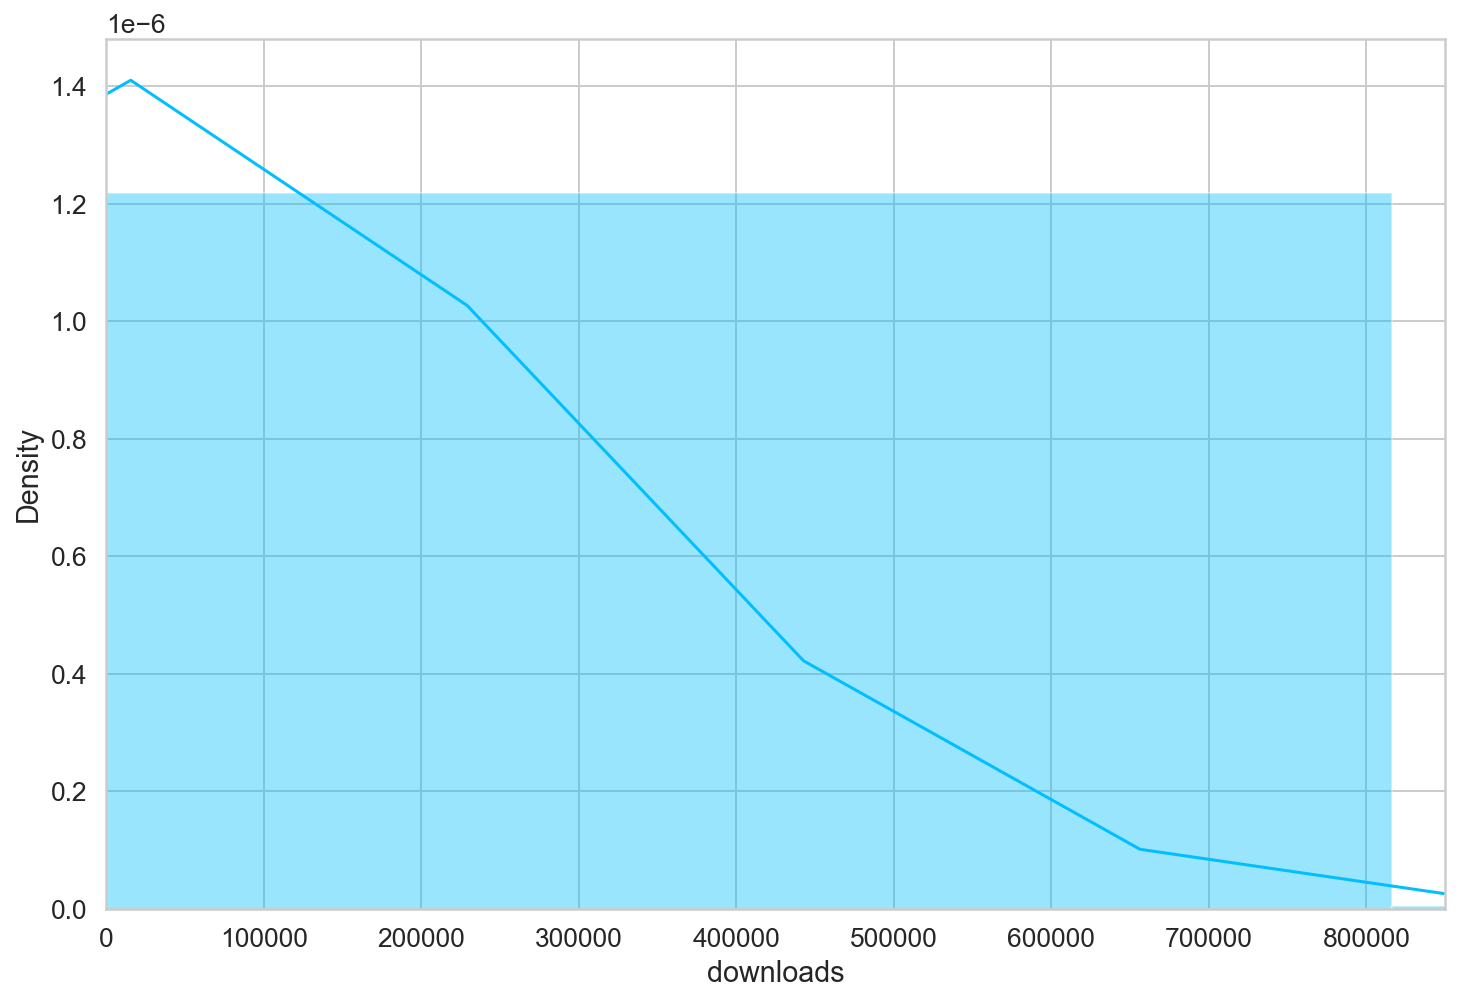

In [62]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
sns.distplot(repo_df['downloads'])

plt.xlim([0, 850000])
plt.xlabel('downloads')

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'downloads')

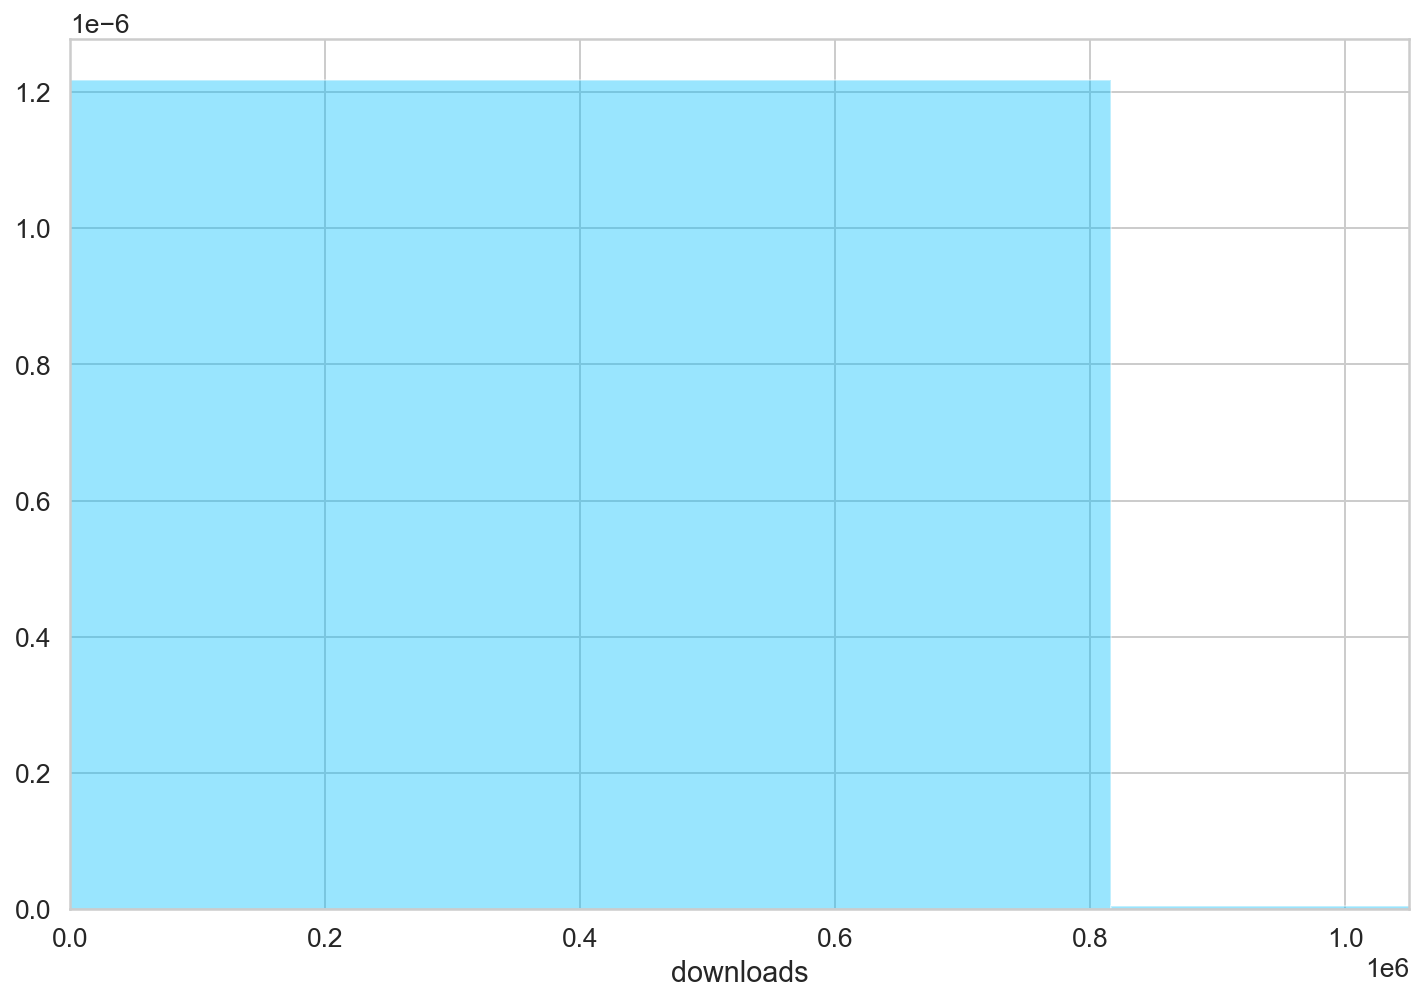

In [63]:
sns.distplot(repo_df['downloads'], kde=False, norm_hist=True, bins=int(50))
plt.xlim([0, 1050000])
plt.xlabel('downloads')

In [64]:
repo_df.shape

(1358, 10)

In [65]:
repo_df[repo_df['downloads'] > 1000]

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme,contributor_count
repo,,,,,,,,,,
4paradigm/OpenMLDB,0,2941,1146,13,0,0,0,{},13438,0
ARM-software/ComputeLibrary,180,30750,716,28,14,0,0,{mdigiorgio},10058,1
ARM-software/armnn,0,1251,343,21,1425,0,0,"{TeresaARM, IsabellaARM, RyanAtArm, Rob-Hughes...",9410,39
AlanRace/SpectralAnalysis,3,1164,11,7,173,30,9,{AlanRace},2039,1
AmusementClub/vs-mlrt,4,1559,28,12,142,3,1,"{AkarinVS, WolframRhodium}",1680,2
...,...,...,...,...,...,...,...,...,...,...
yuyang-huang/keras-inception-resnet-v2,13,1964,32,1,7,2,2,{yuyang-huang},1510,1
zero-one-group/geni,21,2622,188,18,171,25,14,{anthony-khong},16243,1
zhanghang1989/ResNeSt,0,9562,2336,6,31,122,78,{zhanghang1989},7250,1


In [66]:
repo_df['1kdownloads']= np.where(repo_df['downloads'] > 10000, 1, 0)

/var/folders/xq/pylr4t8d08g_cywhg3hhf02w0000gn/T/ipykernel_7079/1743727404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repo_df['1kdownloads']= np.where(repo_df['downloads'] > 10000, 1, 0)


In [67]:
repo_df['1kdownloads'].value_counts()

0    1243
1     115
Name: 1kdownloads, dtype: int64

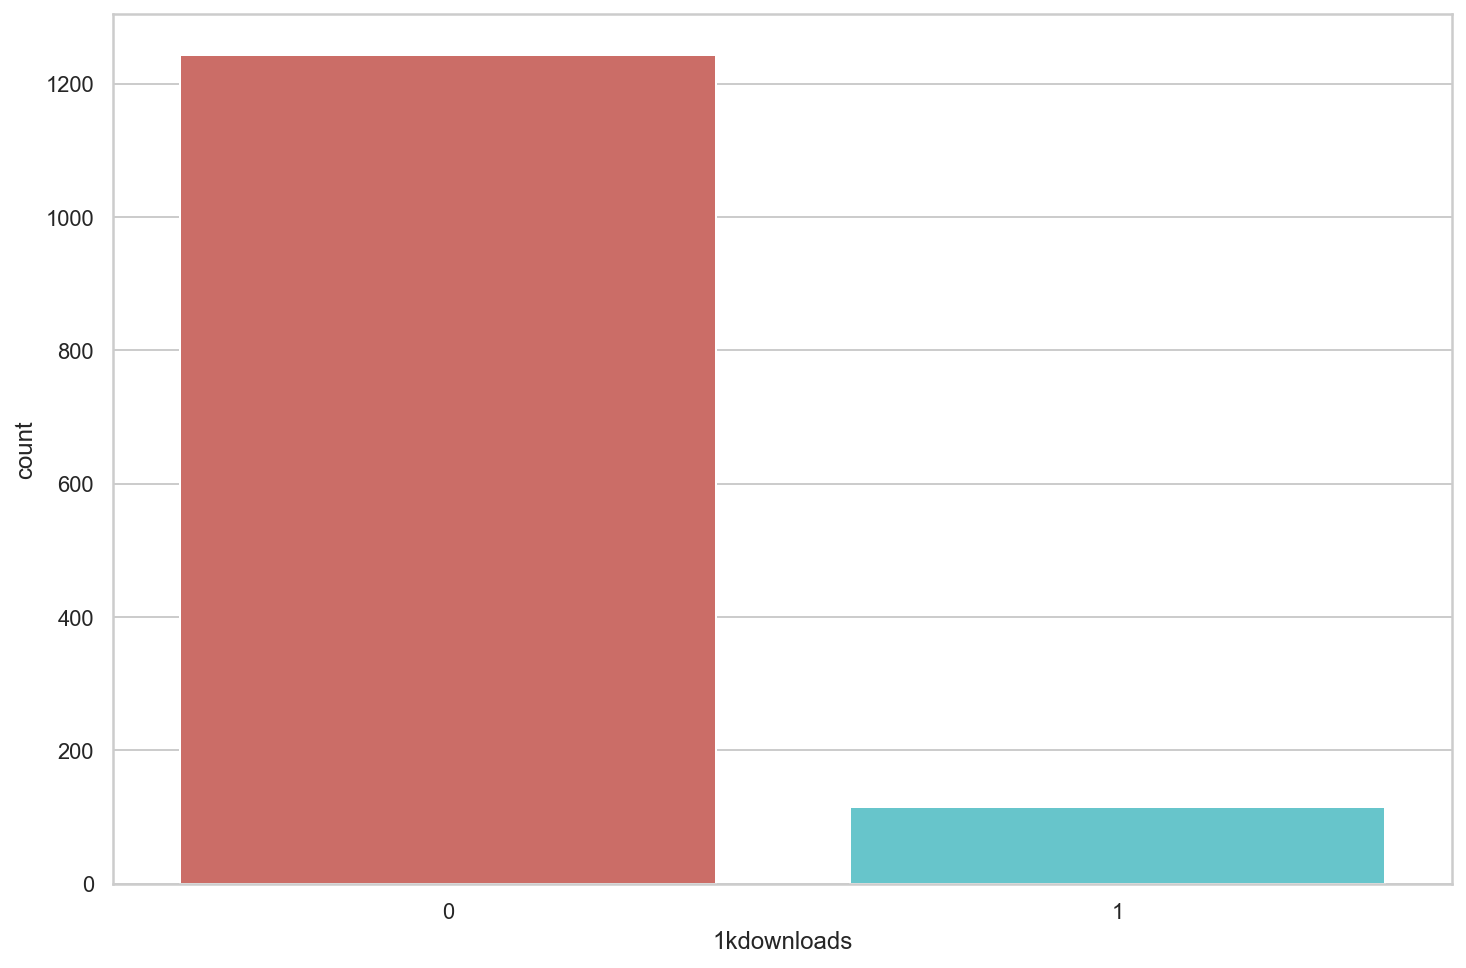

<Figure size 864x576 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='1kdownloads',data=repo_df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [69]:
repo_df.groupby('1kdownloads').mean()

,forks,downloads,stars,release_counts,commits,issues,closedIssues,readme,contributor_count
1kdownloads,,,,,,,,,
0,45.681416,761.312148,256.631537,8.794047,181.576026,10.054706,7.324216,6279.723250,2.362832
1,655.800000,629926.504348,2280.678261,34.530435,429.634783,11.643478,7.226087,7220.991304,6.860870


# Logistic Regression

In [70]:
cols=['forks', 'downloads', 'stars', 'commits', 'issues',
      'closedIssues', 'contributor_count', 'readme', 'release_counts'] 
X=repo_df[cols]
y=repo_df['1kdownloads']
# X,y

In [71]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.183690
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:            1kdownloads   No. Observations:                 1358
Model:                          Logit   Df Residuals:                     1349
Method:                           MLE   Df Model:                            8
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.3667
Time:                        15:49:21   Log-Likelihood:                -249.45
converged:                       True   LL-Null:                       -393.90
Covariance Type:            nonrobust   LLR p-value:                 9.452e-58
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
forks                -0.0007      0.002     -0.324      0.746      -0.005       0.003
downloa

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
y_pred = logreg.predict(X_test)

In [74]:
X_test.shape

(408, 9)

In [75]:
y_test.value_counts()

0    376
1     32
Name: 1kdownloads, dtype: int64

In [76]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96



# Validation

In [77]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7,  shuffle=True)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.953


/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[363  13]
 [  3  29]]


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       376
           1       0.69      0.91      0.78        32

    accuracy                           0.96       408
   macro avg       0.84      0.94      0.88       408
weighted avg       0.97      0.96      0.96       408



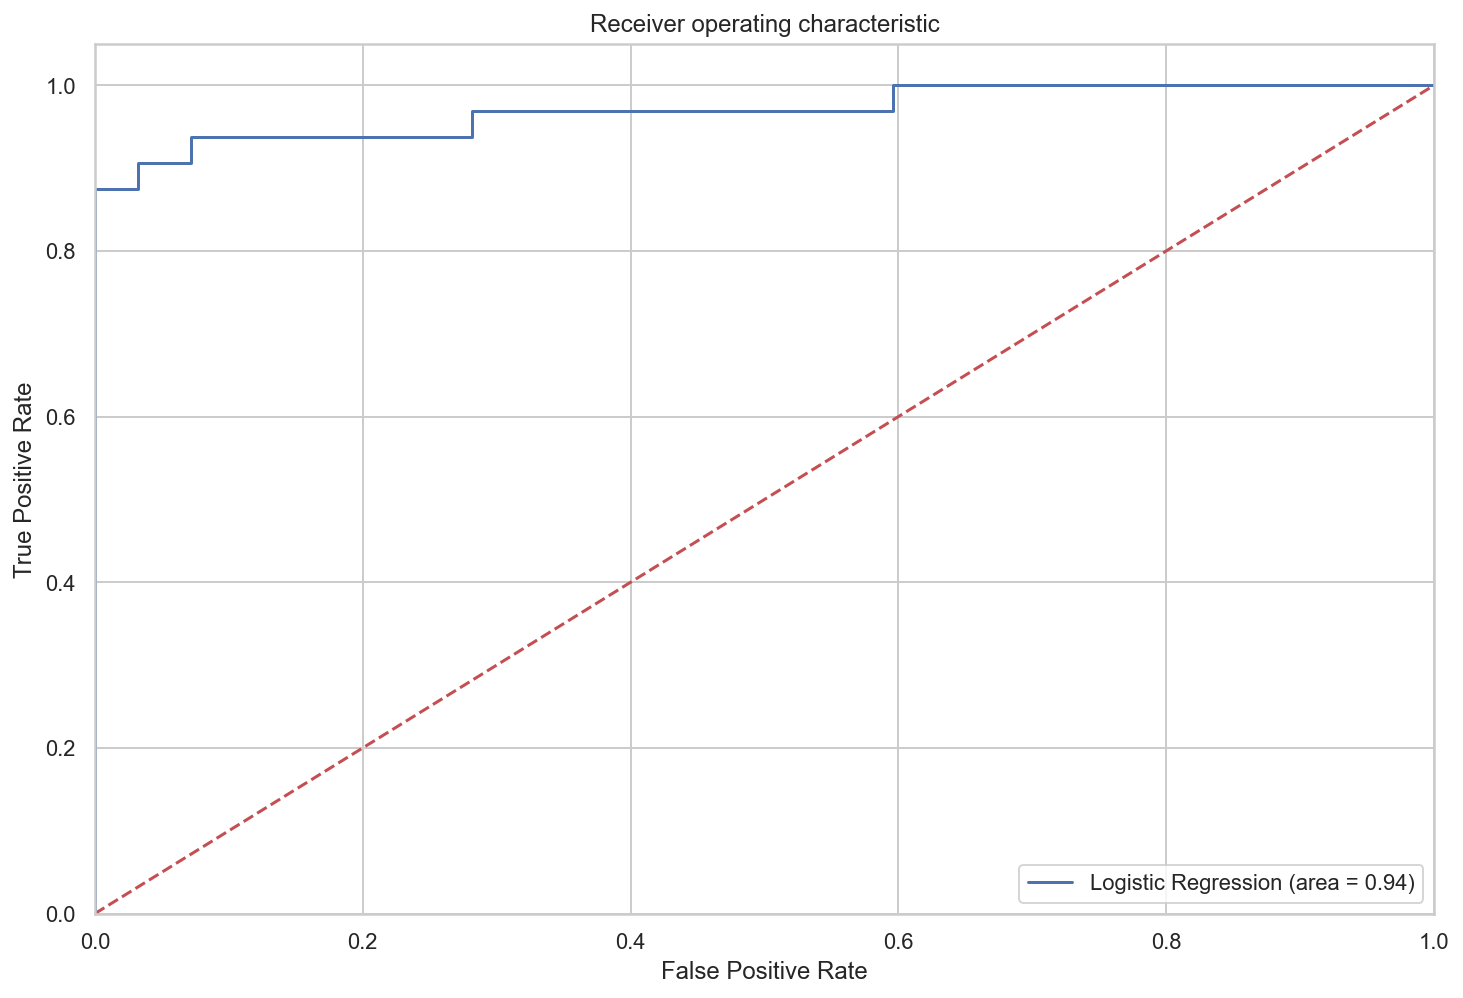

In [80]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_download_ROC')
plt.show()

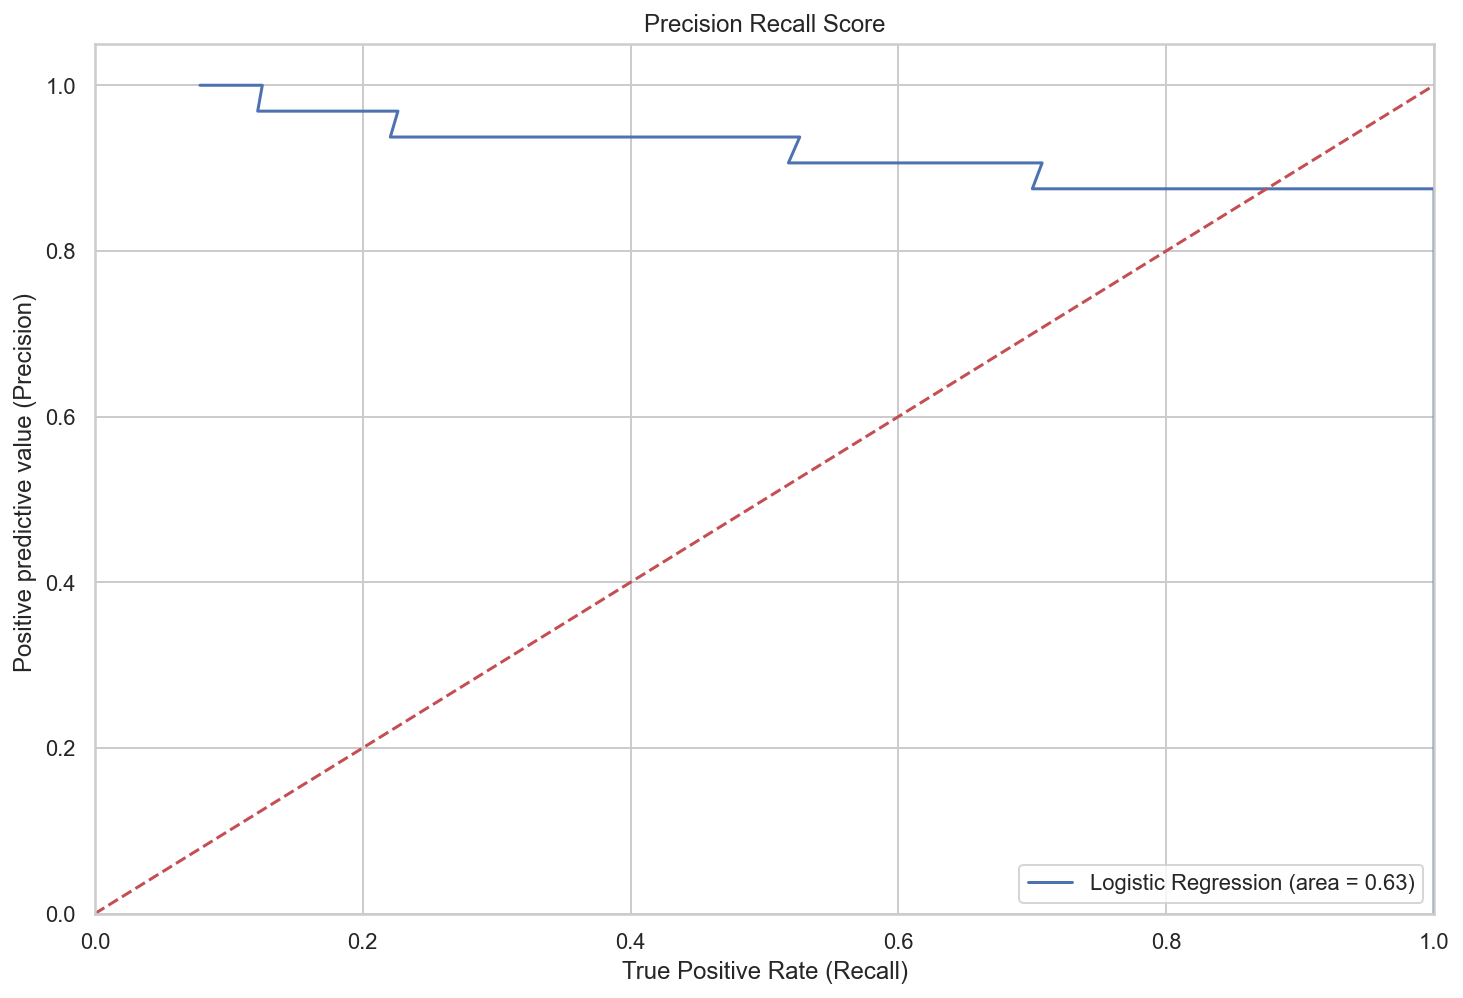

In [81]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
auprc = average_precision_score(y_test, logreg.predict(X_test))
precision, recall, thresholds = precision_recall_curve( y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(precision, recall, label='Logistic Regression (area = %0.2f)' % auprc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Positive Rate (Recall)')
plt.ylabel('Positive predictive value (Precision) ')
plt.title('Precision Recall Score')
plt.legend(loc="lower right")
plt.savefig('Log_download_AUPRC')
plt.show()

# SHAP Analysis

In [82]:
import shap

In [83]:
# Fits the explainer
explainer = shap.Explainer(logreg.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

In [84]:
# Evaluate SHAP values
# shap_values = explainer.shap_values(X)

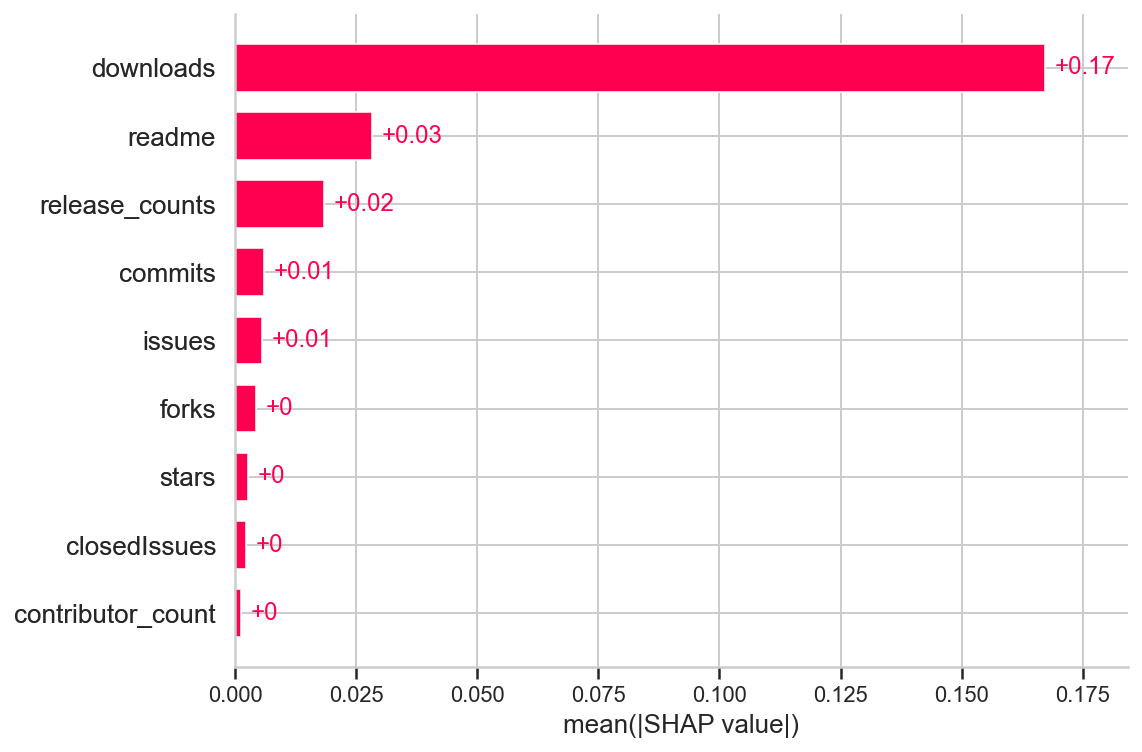

In [85]:
shap.plots.bar(shap_values)


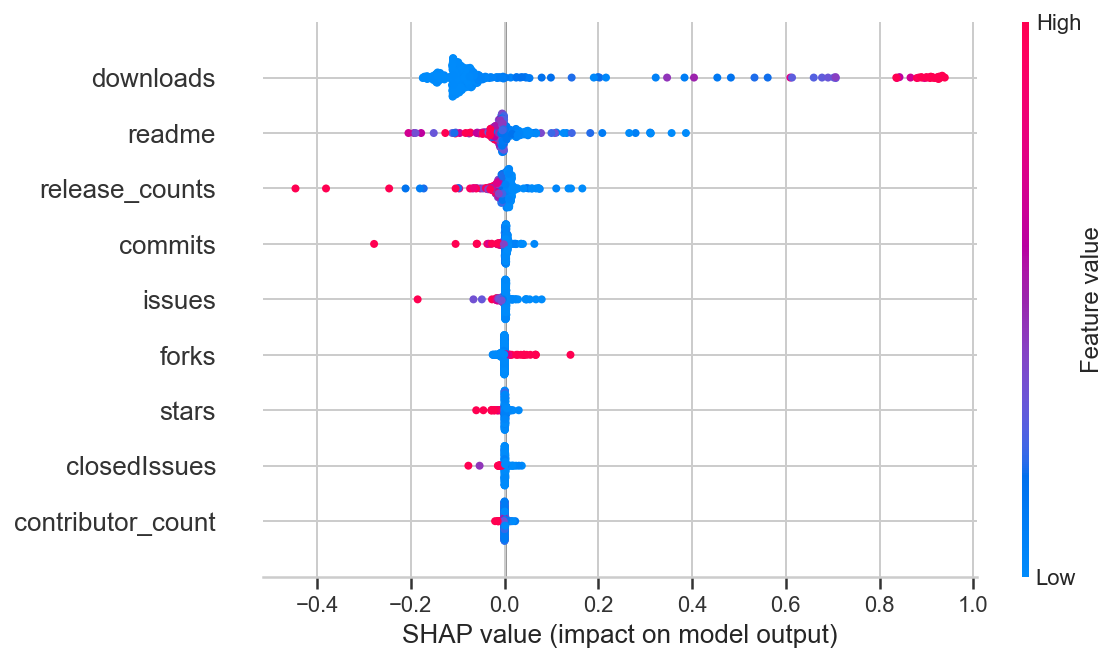

In [86]:
# shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

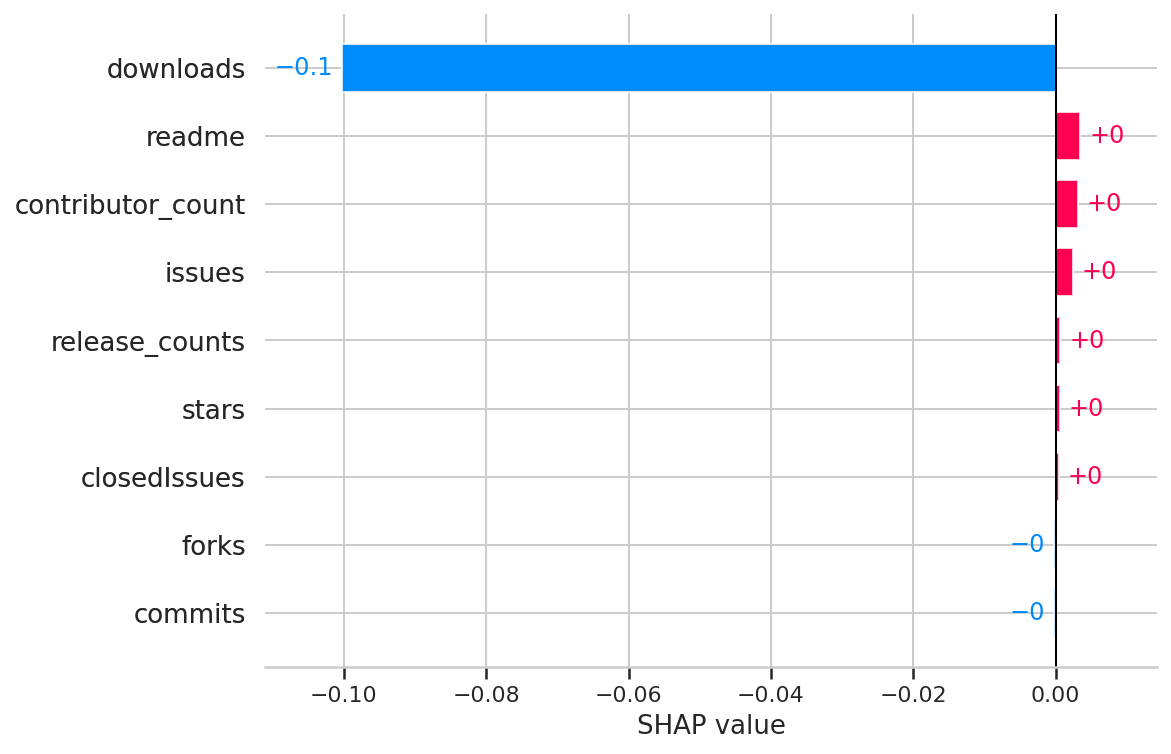

In [47]:
shap.plots.bar(shap_values[0])

In [48]:
# shap.plots.force(shap_test[0])

# XGBoost with Skikit-Learn

In [49]:
import xgboost as xgb
cols=['forks', 'downloads', 'release_counts', 'commits', 'issues', 'closedIssues'] 
X=repo_df[cols]
y=repo_df['1kstars']

KeyError: '1kstars'

In [ ]:
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model.fit(X, y)

# y_pred = xgb_model.predict(X)

# print(confusion_matrix(y, y_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


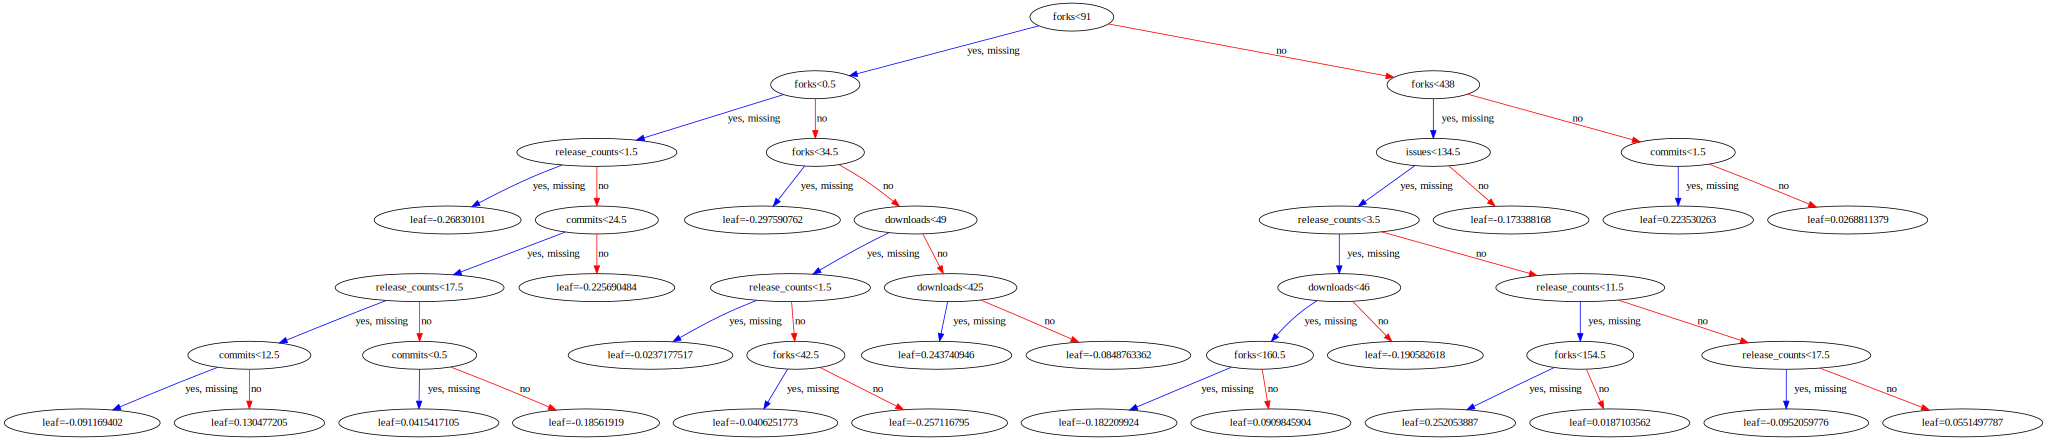

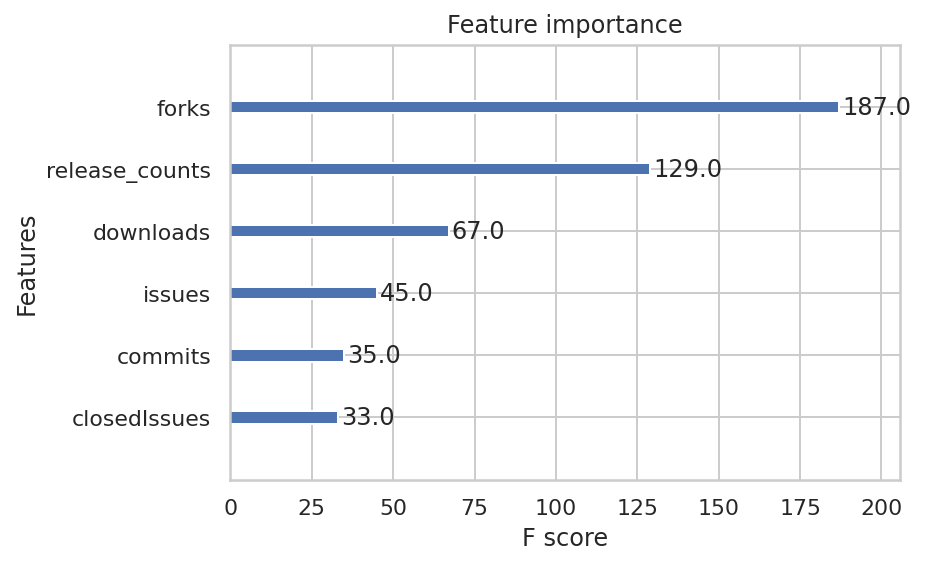

In [37]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [ ]:

from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [ ]:
# fig, ax = plt.subplots(figsize=(30, 30))
# plot_tree(xgb_model, num_trees=0, rankdir='LR')
# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))

plot_tree(xgb_model, num_trees=4, ax=ax)

plt.show()
plt.savefig("tree.pdf")

